# 3. Sequences & Recurrent Neural Networks

Build and train recurrent neural networks (`RNNs`) for processing sequential data such as time series, text, or audio. You will learn about the two most popular recurrent architectures, `Long-Short Term Memory` (`LSTM`) and Gated Recurrent Unit (`GRU`) networks, as well as how to prepare sequential data for model training. You will practice your skills by training and evaluating a recurrent model for predicting electricity consumption.

## Preparing the environment

In [1]:
# Importing libraries
import expectexception
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment
from typing import Tuple

from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import MeanSquaredError

In [2]:
# Global variables
SEED = 42

DATASET_ELECTRICITY_CONSUMPTION_TRAIN = 'data-sources/electricity_train.csv'
DATASET_ELECTRICITY_CONSUMPTION_TEST = 'data-sources/electricity_test.csv'

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

2.4.1+cu124
Cuda is available? True


In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

## 3.1 Handling sequences with PyTorch

### Sequential data

- Ordered in time or space
- Order of the data points contains dependencies between them
- Examples of sequential data:
    - Time series
    - Text
    - Audio waves

### Electricity consumption Dataset

In [5]:
print('TRAIN DATASET:')
df_train = pd.read_csv(DATASET_ELECTRICITY_CONSUMPTION_TRAIN, parse_dates=['timestamp'])
print(df_train.describe(include='all'))
print(df_train.shape)
df_train

TRAIN DATASET:
                           timestamp    consumption
count                         105215  105215.000000
mean   2012-07-01 23:59:59.999999744      -0.007469
min              2011-01-01 00:15:00      -1.414483
25%              2011-10-02 00:07:30      -0.957931
50%              2012-07-02 00:00:00      -0.349363
75%              2013-04-01 23:52:30       0.797593
max              2013-12-31 23:45:00       3.028924
std                              NaN       1.056835
(105215, 2)


,timestamp,consumption
0,2011-01-01 00:15:00,-0.704319
1,2011-01-01 00:30:00,-0.704319
2,2011-01-01 00:45:00,-0.678983
3,2011-01-01 01:00:00,-0.653647
4,2011-01-01 01:15:00,-0.704319
...,...,...
105210,2013-12-31 22:45:00,-0.932595
105211,2013-12-31 23:00:00,-0.907259
105212,2013-12-31 23:15:00,-0.932595
105213,2013-12-31 23:30:00,-0.932595


In [6]:
print('TEST DATASET:')
df_test = pd.read_csv(DATASET_ELECTRICITY_CONSUMPTION_TEST, parse_dates=['timestamp'])
print(df_test.describe(include='all'))
print(df_test.shape)
df_test

TEST DATASET:
                 timestamp   consumption
count                35040  35040.000000
mean   2014-07-02 11:52:30      0.022430
min    2014-01-01 00:00:00     -1.414483
25%    2014-04-02 05:56:15     -0.729908
50%    2014-07-02 11:52:30     -0.095751
75%    2014-10-01 17:48:45      0.695742
max    2014-12-31 23:45:00      2.645845
std                    NaN      0.805208
(35040, 2)


,timestamp,consumption
0,2014-01-01 00:00:00,-0.932595
1,2014-01-01 00:15:00,-0.957931
2,2014-01-01 00:30:00,-0.932595
3,2014-01-01 00:45:00,-0.907259
4,2014-01-01 01:00:00,-0.881923
...,...,...
35035,2014-12-31 22:45:00,-0.070415
35036,2014-12-31 23:00:00,-0.045079
35037,2014-12-31 23:15:00,-0.045079
35038,2014-12-31 23:30:00,-0.045079


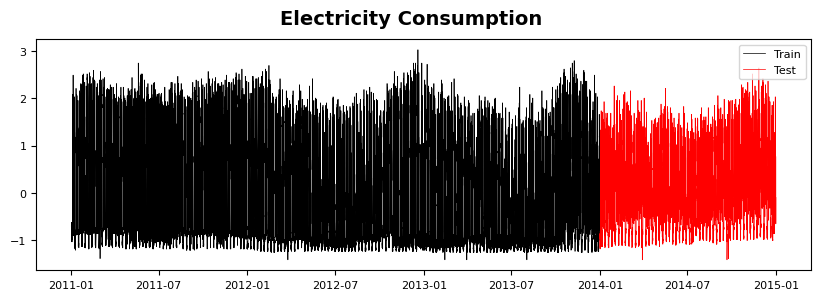

In [7]:
fig = plt.figure(figsize=(10, 3))
plt.plot(df_train.timestamp, df_train.consumption, c='black', lw=.5, label='Train')
plt.plot(df_test.timestamp, df_test.consumption, c='red', lw=.5, label='Test')
plt.legend()
fig.suptitle('Electricity Consumption')
plt.show()

### Creating sequences in Python

Applicability also to other sequential data:

- Same techniques are applicable to other sequences:
- Large Language Models
- Speech recognition

In [8]:
def create_sequences1(df: pd.DataFrame, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i+seq_length), 1]
        y = df.iloc[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
start = time.time()
xs, ys = create_sequences1(df_train, 100000)
print(xs[-2:])
print(xs.shape)
print(ys.shape)
print(f'\nExecution time: {time.time()-start} s.')

[[-0.8312513  -0.8312513  -0.32402689 ... -0.93259484 -0.90725895
  -0.93259484]
 [-0.8312513  -0.32402689  0.74666758 ... -0.90725895 -0.93259484
  -0.93259484]]
(5215, 100000)
(5215,)

Execution time: 1.733351707458496 s.


In [10]:
def create_sequences2(df: pd.DataFrame, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    num_features = len(df) - seq_length
    xs = np.array([df.iloc[i:(i+seq_length), 1] for i in range(num_features)])
    ys = np.array([df.iloc[i+seq_length, 1] for i in range(num_features)])
    return xs, ys

In [11]:
start = time.time()
xs, ys = create_sequences2(df_train, 100000)
print(xs[-2:])
print(xs.shape)
print(ys.shape)
print(f'\nExecution time: {time.time()-start} s.')

[[-0.8312513  -0.8312513  -0.32402689 ... -0.93259484 -0.90725895
  -0.93259484]
 [-0.8312513  -0.32402689  0.74666758 ... -0.90725895 -0.93259484
  -0.93259484]]
(5215, 100000)
(5215,)

Execution time: 5.385654449462891 s.


In [12]:
def create_sequences3(df: pd.DataFrame, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    data = df.iloc[:, 1].values                                           # Extract the column as NumPy array
    xs = np.lib.stride_tricks.sliding_window_view(data[:-1], seq_length)  # Sliding windows of size `seq_length`
    ys = data[seq_length:]                                                # Target values (next val after sequence)
    return xs, ys

In [13]:
start = time.time()
xs, ys = create_sequences3(df_train, 100000)
print(xs[-2:])
print(xs.shape)
print(ys.shape)
print(f'\nExecution time: {time.time()-start} s.')

[[-0.8312513  -0.8312513  -0.32402689 ... -0.93259484 -0.90725895
  -0.93259484]
 [-0.8312513  -0.32402689  0.74666758 ... -0.90725895 -0.93259484
  -0.93259484]]
(5215, 100000)
(5215,)

Execution time: 0.4359865188598633 s.


In [14]:
def create_sequences4(df: pd.DataFrame, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    data = df.iloc[:, 1].values
    num_features = len(df) - seq_length
    xs = np.array([data[i:(i+seq_length)] for i in range(num_features)])
    ys = np.array([data[i+seq_length] for i in range(num_features)])
    return xs, ys

In [15]:
start = time.time()
xs, ys = create_sequences4(df_train, 100000)
print(xs.shape)
print(ys.shape)
print(f'\nExecution time: {time.time()-start} s.')

(5215, 100000)
(5215,)

Execution time: 0.8241095542907715 s.


### TensorDataset

In [16]:
# Create training examples
seq_length = 100000
X_train, y_train = create_sequences3(df_train, seq_length)  # Most rapid method
print(X_train.shape, y_train.shape)

# Convert them to a Torch Dataset
dataset_train = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
print(len(dataset_train))

(5215, 100000) (5215,)
5215


### Ex.1 - Generating sequences
To be able to train neural networks on sequential data, you need to pre-process it first. You'll chunk the data into inputs-target pairs, where the inputs are some number of consecutive data points and the target is the next data point.

Your task is to define a function to do this called `create_sequences()`. As inputs, it will receive data stored in a DataFrame, `df` and `seq_length`, the length of the inputs. As outputs, it should return two NumPy arrays, one with input sequences and the other one with the corresponding targets.

As a reminder, here is how the DataFrame `df` looks like:
```
                 timestamp  consumption
0      2011-01-01 00:15:00    -0.704319
...                    ...          ...
140255 2015-01-01 00:00:00    -0.095751
```

**Instructions**

1. Iterate over the range of the number of data points minus the length of an input sequence.
2. Define the inputs `x` as the slice of `df` from the `i`th row to the `i + seq_lengthth` row and the column at index `1`.
3. Define the target `y` as the slice of `df` at row index `i + seq_length` and the column at index `1`.

----------------------------------
```
import numpy as np

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i:(i+seq_length), 1]
        # Define target
        y = df.iloc[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
```

### Ex.2 - Sequential Dataset

Good job building the `create_sequences()` function! It's time to use it to create a training dataset for your model.

Just like tabular and image data, sequential data is easiest passed to a model through a torch Dataset and DataLoader. To build a sequential Dataset, you will call `create_sequences()` to get the NumPy arrays with inputs and targets, and inspect their shape. Next, you will pass them to a `TensorDataset` to create a proper torch Dataset, and inspect its length.

Your implementation of `create_sequences()` and a DataFrame with the training data called `train_data` are available.

**Instructions**

1. Call `create_sequences()`, passing it the training DataFrame and a sequence length of `24*4`, assigning the result to `X_train`, `y_train`.
2. Define `dataset_train` by calling `TensorDataset` and passing it two arguments, the inputs and the targets created by `create_sequences()`, both converted from NumPy arrays to tensors of floats.

----------------------------------
```
import torch
from torch.utils.data import TensorDataset

# Use create_sequences to create inputs and targets
X_train, y_train = create_sequences(train_data, 24*4)
print(X_train.shape, y_train.shape)

# Create TensorDataset
dataset_train = TensorDataset(
    torch.tensor(X_train).float(),
    torch.tensor(y_train).float(),
)
print(len(dataset_train))
```

In [17]:
# Use create_sequences to create inputs and targets
xs, ys = create_sequences3(df=df_train, seq_length=24*4)
print(xs.shape, ys.shape)

# Create TensorDataset
dataset_train = TensorDataset(torch.tensor(xs).float(), torch.tensor(ys).float())
print(len(dataset_train))

(105119, 96) (105119,)
105119


## 3.2 Recurrent Neural Networks

**4 architectures:**

### Sequence-to-sequence architecture
- Pass sequence as input and make use of the output produced at every time step.
- Use the entire output sequence.
- **Example**: Real-time speech recognition could receive audio at each time step and output the corresponding text.

### Sequence-to-vector architecture $ \star\star\star $
- Pass sequence as input, but ignore all the outputs but the last one.
- Use only the last output.
- In other words, we let the model process the entire input sequence before it produces the output.
- **Example**: Text topic classification.
- We will use the `sequence-to-vector` architecture for electricity consumption prediction.

### Vector-to-sequence architecture
- Pass single input and replace all the other inputs with zeros but make use of all the outputs from each time step.
- Use the entire output sequence.
- **Example**: Text generation.

### Encoder-decoder architecture
- Pass entire input sequence and only then start using output sequence.
- This is different from sequence to sequence in which outputs are generated while the inputs are still being received.
- **Example**: Machine translation. One cannot translate word by word, rather the entire input must be processed before output generation can start.

### RNN Model - RnnSeqToVectorModel

In [18]:
class RnnSeqToVectorModel(nn.Module):
    """RNN Sequence to vector model to predict electricity consumption.."""
    def __init__(self):
        super().__init__()
        torch.manual_seed(SEED)  # Reproducibility
        self.rnn = nn.RNN(       # Define the RNN model
            input_size=1,        # Only one feature, electricity consumption
            hidden_size=32,      # Choosen arbitrary
            num_layers=2,        # Choosen arbitrary
            batch_first=True,    # Batch Size will be it first dimension
        )
        self.fc = nn.Linear(32, 1)  # Linear layer for the hidden size (32) to the output (1)
        
    def forward(self, x):
        # 1st hidden state shape: num_layers (2) X input size (X.size-0) X hidden_size (32)
        h0 = torch.zeros(2, x.size(0), 32)  # Init the first hidden state to 0,             
        out, _ = self.rnn(x, h0)            # Pass input x and hidden state (h0) by RNN model
        out = self.fc(out[:, -1, :])        # select last output (middel dimension) to return
        return out

temp = RnnSeqToVectorModel()
temp

RnnSeqToVectorModel(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### Ex.3 - Building a forecasting RNN
It's time to build your first recurrent network! It will be a sequence-to-vector model consisting of an RNN layer with two layers and a `hidden_size` of `32`. After the RNN layer, a simple linear layer will map the outputs to a single value to be predicted.

The following imports have already be done for you:
```
import torch
import torch.nn as nn
```

**Instructions**

1. Define the RNN layer passing it the correct values for `input_size`, `hidden_size`, `num_layers`, and `batch_first`, and assign it to `self.rnn`.

-------------------------------------------
```
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(2, x.size(0), 32)
        # Pass x and h0 through recurrent layer
        out, _ = self.rnn(x, h0)  
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out
```

## 3.3 LSTM and GRU cells

### RNN - Short-term memory problem
- RNN cells maintain memory via hidden state
- This memory is very short-term
- Two more powerful cells solve the problem:
    - LSTM (Long Short-Term Memory) cell
    - GRU (Gated Recurrent Unit) cell

### Should I use RNN, LSTM, or GRU?
- RNN is not used much anymore
- GRU is simpler than LSTM = less computation
- Relative performance varies per use-case
- Try both and compare

### LSTM Model - LstmSeqToVectorModel
- LSTM (Long Short-Term Memory)

In [19]:
class LstmSeqToVectorModel(nn.Module):
    """LSTM Sequence to vector model to predict electricity consumption."""
    def __init__(self):
        super().__init__()
        torch.manual_seed(SEED)  # Reproducibility
        self.lstm = nn.LSTM(     # Define the LSTM model
            input_size=1,        # Only one feature, electricity consumption
            hidden_size=32,      # Choosen arbitrary
            num_layers=2,        # Choosen arbitrary
            batch_first=True,    # Batch Size will be it first dimension
        )
        self.fc = nn.Linear(32, 1)  # Linear layer for hidden size (32) to output (1)
        
    def forward(self, x):
        # Shape of hidden h0 and c0:
        # >> num_layers (2) X input size (X.size-0) X hidden_size (32)
        h0 = torch.zeros(2, x.size(0), 32)  # Init 1st short-term state to 0                 
        c0 = torch.zeros(2, x.size(0), 32)  # Init 1st long-term state to 0
        out, _ = self.lstm(x, (h0, c0))     # Pass input x, h0 and h1 by RNN
        out = self.fc(out[:, -1, :])        # Return last output (middel dim)
        return out

temp = LstmSeqToVectorModel()
temp

LstmSeqToVectorModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### GRU Model - GruSeqToVectorModel
- GRU (Gated Recurrent Unit)

In [20]:
class GruSeqToVectorModel(nn.Module):
    """GRU Sequence to vector model to predict electricity consumption."""
    def __init__(self):
        super().__init__()
        torch.manual_seed(SEED)  # Reproducibility
        self.gru = nn.GRU(       # Define the GRU model
            input_size=1,        # Only one feature, electricity consumption
            hidden_size=32,      # Choosen arbitrary
            num_layers=2,        # Choosen arbitrary
            batch_first=True,    # Batch Size will be it first dimension
        )
        self.fc = nn.Linear(32, 1)  # Linear layer for hidden size (32) to output (1)
        
    def forward(self, x):
        # Shape of h0: num_layers (2) X input size (X.size-0) X hidden_size (32)
        h0 = torch.zeros(2, x.size(0), 32)  # Init 1st short-term state to 0                 
        out, _ = self.gru(x, h0)            # Pass input x, h0 by RNN
        out = self.fc(out[:, -1, :])        # Return last output (middel dim)
        return out

temp = GruSeqToVectorModel()
temp

GruSeqToVectorModel(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### Ex.4 - LSTM network

As you already know, plain `RNN` cells are not used that much in practice. A more frequently used alternative that ensures a much better handling of long sequences are Long Short-Term Memory cells, or `LSTM`s. In this exercise, you will be build an `LSTM` network yourself!

The most important implementation difference from the `RNN` network you have built previously comes from the fact that `LSTM`s have two rather than one hidden states. This means you will need to initialize this additional hidden state and pass it to the `LSTM` cell.

`torch` and `torch.nn` have already been imported for you, so start coding!

**Instructions**

1. In the `.__init__()` method, define an `LSTM` layer and assign it to `self.lstm`.
2. In the `forward()` method, initialize the first long-term memory hidden state `c0` with zeros.
3. In the `forward()` method, pass all three inputs to the `LSTM` layer: the current time step's inputs, and a tuple containing the two hidden states.

-----------------------------------------------
```
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        # Initialize long-term memory
        c0 = torch.zeros(2, x.size(0), 32)
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
```

### Ex.5 - GRU network

Next to `LSTM`s, another popular recurrent neural network variant is the Gated Recurrent Unit, or `GRU`. It's appeal is in its simplicity: `GRU` cells require less computation than LSTM cells while often matching them in performance.

The code you are provided with is the `RNN` model definition that you coded previously. Your task is to adapt it such that it produces a `GRU` network instead. 

`torch` and `torch.nn as nn` have already been imported for you.

**Instructions**

1. Update the `RNN` model definition in order to obtain a `GRU` network.

------------------------------------------
```
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)  
        out = self.fc(out[:, -1, :])
        return out
```

## 3.4 Training and evaluating RNNs

### Mean Squared Error Loss

- Commonly used in regression problems.
- Squaring the error:
    - Ensures positive and negative errors don't cancel out
    - Penalizes large errors more

In [21]:
nn.MSELoss()

MSELoss()

### Tensors Operations Overview

#### Expanding tensors

In [22]:
### First escenario
temp = torch.randn(2, 4)

print(f"""
Original: 
{temp}

1st change (expansion 1): 
{temp.view(2, 4, 1)}

2nd change (expansion 2): 
{temp.view(1, 2, 4)}
""")


Original: 
tensor([[ 0.3940836787,  0.1002244875,  0.6349968910,  0.2338399291],
        [-0.3849041760, -0.8730549216, -0.2335455120,  1.0561904907]])

1st change (expansion 1): 
tensor([[[ 0.3940836787],
         [ 0.1002244875],
         [ 0.6349968910],
         [ 0.2338399291]],

        [[-0.3849041760],
         [-0.8730549216],
         [-0.2335455120],
         [ 1.0561904907]]])

2nd change (expansion 2): 
tensor([[[ 0.3940836787,  0.1002244875,  0.6349968910,  0.2338399291],
         [-0.3849041760, -0.8730549216, -0.2335455120,  1.0561904907]]])



In [23]:
### Second escenario
temp = torch.randn(4, 1)

print(f"""
Original (2, 4): 
{temp}

1st change (expansion 1): 
{temp.view(1, -1)}

2nd change (expansion 2): 
{temp.view(1, 1,-1)}

3rd change (expansion 3): 
{temp.view(-1)}
""")


Original (2, 4): 
tensor([[ 0.4316742420],
        [-0.1794083267],
        [ 1.1351015568],
        [-1.0428406000]])

1st change (expansion 1): 
tensor([[ 0.4316742420, -0.1794083267,  1.1351015568, -1.0428406000]])

2nd change (expansion 2): 
tensor([[[ 0.4316742420, -0.1794083267,  1.1351015568, -1.0428406000]]])

3rd change (expansion 3): 
tensor([ 0.4316742420, -0.1794083267,  1.1351015568, -1.0428406000])



#### Squeezing tensors

In [24]:
### First escenario
temp = torch.randn(4, 1)

print(f"""
Original: 
{temp}

Squeeze change: 
{temp.squeeze()}
""")


Original: 
tensor([[0.4650663137],
        [0.9289101362],
        [1.1308556795],
        [0.5203239322]])

Squeeze change: 
tensor([0.4650663137, 0.9289101362, 1.1308556795, 0.5203239322])



In [25]:
### Second escenario
temp = torch.randn(1, 4, 2, 1)

print(f"""
Expanding tensors:

Original: 
{temp.shape}

Squeeze change 1: (remove all 1 element contained in dimension)
{temp.squeeze().shape}

Squeeze change 2: (remove dim=0, if there is only one element)
{temp.squeeze(dim=0).shape}

Squeeze change 3: (remove dim=1, no removed as there is no just one element)
{temp.squeeze(dim=1).shape}
""")


Expanding tensors:

Original: 
torch.Size([1, 4, 2, 1])

Squeeze change 1: (remove all 1 element contained in dimension)
torch.Size([4, 2])

Squeeze change 2: (remove dim=0, if there is only one element)
torch.Size([4, 2, 1])

Squeeze change 3: (remove dim=1, no removed as there is no just one element)
torch.Size([1, 4, 2, 1])



### Data Loaders preparation

In [26]:
# Create Train TensorDataset
xs, ys = create_sequences3(df=df_train, seq_length=24*4)
dataset_train = TensorDataset(torch.tensor(xs[31:]).float(),
                              torch.tensor(ys[31:]).float())
print(f"""
Train set:
Sequence shape: {xs.shape}, Target shape: {ys.shape}
Dataset len: {len(dataset_train)}
""")

# Create Test TensorDataset
xs, ys = create_sequences3(df=df_test, seq_length=24*4)
dataset_test = TensorDataset(torch.tensor(xs).float(),
                             torch.tensor(ys).float())
print(f"""
Test set:
Sequence shape: {xs.shape}, Target shape: {ys.shape}
Dataset len: {len(dataset_test)}
""")


Train set:
Sequence shape: (105119, 96), Target shape: (105119,)
Dataset len: 105088


Test set:
Sequence shape: (34944, 96), Target shape: (34944,)
Dataset len: 34944



### Training loop - RNN

In [27]:
# Create the data loader
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=16)
dataloader_test = DataLoader(dataset_test, shuffle=True, batch_size=32)

# Build the model
rnn_model = RnnSeqToVectorModel()

# Set the criterion and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

In [28]:
# training loop
losses_rnn = []
epochs = 10
rnn_model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:        # Get feature and target from the data loader
        optimizer.zero_grad()            # zero the parameter gradients
        X = X.view(16, 96, 1)            # prev=(32, 96), post=(32, 96, 1)
        y_pred = rnn_model(X)            # Run a forward pass
        y_pred = y_pred.squeeze()        # prev=(32,1), post=(32)
        loss = criterion(y_pred, y)      # Compute loss
        loss.backward()                  # Backward pass
        optimizer.step()                 # Optimization

    losses_rnn.append(loss.item())           # Record the loss per epoch
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.6f}')

Epoch [1], Loss: 0.122134
Epoch [2], Loss: 0.028624
Epoch [3], Loss: 0.002763
Epoch [4], Loss: 0.057949
Epoch [5], Loss: 0.036531
Epoch [6], Loss: 0.002225
Epoch [7], Loss: 0.004918
Epoch [8], Loss: 0.016405
Epoch [9], Loss: 0.073045
Epoch [10], Loss: 0.003221


#### Evaluation loop - RNN

In [29]:
mse = MeanSquaredError()

rnn_model.eval()
with torch.no_grad():
    for X, y in dataloader_test:
        X = X.view(32, 96, 1)
        y_pred = rnn_model(X).squeeze()
        mse(y_pred, y)
rnn_mse = mse.compute()
print(f"Test MSE: {rnn_mse}")
mse.reset()

Test MSE: 0.051596201956272125


In [30]:
predicted_df = pd.DataFrame({
    'y_true': y.numpy(),
    'y_pred RNN': y_pred.numpy(),
    'RNN Dif': y.numpy() - y_pred.numpy()
})

### Training loop - LSTM

In [31]:
# Create the data loader
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=16)
dataloader_test = DataLoader(dataset_test, shuffle=True, batch_size=32)

# Build the model
lstm_model = LstmSeqToVectorModel()

# Set the criterion and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [32]:
# training loop
losses_lstm = []
epochs = 10
lstm_model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:        # Get feature and target from the data loader
        optimizer.zero_grad()            # zero the parameter gradients
        X = X.view(16, 96, 1)            # prev=(32, 96), post=(32, 96, 1)
        y_pred = lstm_model(X).squeeze() # Run a forward pass
        loss = criterion(y_pred, y)      # Compute loss
        loss.backward()                  # Backward pass
        optimizer.step()                 # Optimization

    losses_lstm.append(loss.item())      # Record the loss per epoch
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.6f}')

Epoch [1], Loss: 0.007406
Epoch [2], Loss: 0.010824
Epoch [3], Loss: 0.010782
Epoch [4], Loss: 0.003647
Epoch [5], Loss: 0.007436
Epoch [6], Loss: 0.003303
Epoch [7], Loss: 0.005534
Epoch [8], Loss: 0.004433
Epoch [9], Loss: 0.075897
Epoch [10], Loss: 0.021503


#### Evaluation loop - LSTM

In [33]:
mse = MeanSquaredError()

lstm_model.eval()
with torch.no_grad():
    for X, y in dataloader_test:
        X = X.view(32, 96, 1)
        y_pred = lstm_model(X).squeeze()
        mse(y_pred, y)
lstm_mse = mse.compute()
print(f"Test MSE: {lstm_mse}")

Test MSE: 0.051294200122356415


In [34]:
predicted_df['y_pred LSTM'] = y_pred.numpy()
predicted_df['LSTM Dif'] = y.numpy() - y_pred.numpy()

### Training loop - GRU

In [35]:
# Create the data loader
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=16)
dataloader_test = DataLoader(dataset_test, shuffle=True, batch_size=32)

# Build the model
gru_model = GruSeqToVectorModel()

# Set the criterion and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

In [36]:
# training loop
losses_gru = []
epochs = 10
gru_model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:        # Get feature and target from the data loader
        optimizer.zero_grad()            # zero the parameter gradients
        X = X.view(16, 96, 1)            # prev=(32, 96), post=(32, 96, 1)
        y_pred = gru_model(X).squeeze() # Run a forward pass
        loss = criterion(y_pred, y)      # Compute loss
        loss.backward()                  # Backward pass
        optimizer.step()                 # Optimization

    losses_gru.append(loss.item())           # Record the loss per epoch
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.6f}')

Epoch [1], Loss: 0.004984
Epoch [2], Loss: 0.018639
Epoch [3], Loss: 0.007358
Epoch [4], Loss: 0.020901
Epoch [5], Loss: 0.004643
Epoch [6], Loss: 0.003729
Epoch [7], Loss: 0.146876
Epoch [8], Loss: 0.009133
Epoch [9], Loss: 0.107220
Epoch [10], Loss: 0.049834


#### Evaluation loop - GRU

In [37]:
mse = MeanSquaredError()

gru_model.eval()
with torch.no_grad():
    for X, y in dataloader_test:
        X = X.view(32, 96, 1)
        y_pred = gru_model(X).squeeze()
        mse(y_pred, y)
gru_mse = mse.compute()
print(f"Test MSE: {gru_mse}")

Test MSE: 0.06376148760318756


In [38]:
predicted_df['y_pred GRU'] = y_pred.numpy()
predicted_df['GRU Dif'] = y.numpy() - y_pred.numpy()

### Comparisson RNN vs LSTM vs GRU

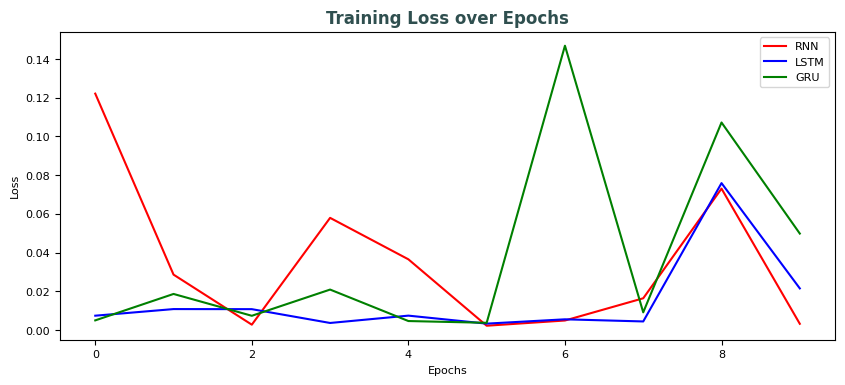

In [39]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses_rnn, label='RNN', color='Red')
plt.plot(range(epochs), losses_lstm, label='LSTM', color='Blue')
plt.plot(range(epochs), losses_gru, label='GRU', color='Green')
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
print(f"RNN  Test MSE: {rnn_mse}")
print(f"LSTM Test MSE: {lstm_mse}")
print(f"GRU  Test MSE: {gru_mse}")

RNN  Test MSE: 0.051596201956272125
LSTM Test MSE: 0.051294200122356415
GRU  Test MSE: 0.06376148760318756


In [41]:
# Reviewing results
predicted_df

,y_true,y_pred RNN,RNN Dif,y_pred LSTM,LSTM Dif,y_pred GRU,GRU Dif
0,-1.084864,-1.095278,0.010415,-0.135892,0.090813,0.254713,0.110650
1,-0.501631,-0.300247,-0.201385,1.300826,-0.071003,0.450364,-0.085002
2,-0.755244,-0.698438,-0.056806,0.032168,-0.001239,-1.079154,0.019626
3,0.466959,0.643068,-0.176108,-0.135830,0.090752,1.545654,0.040138
4,0.030929,0.099334,-0.068405,0.047495,0.394129,-0.736480,0.057498
5,-0.450960,-0.238825,-0.212135,-0.480552,1.074698,-0.420404,-0.030556
6,-0.831251,-0.874505,0.043254,0.825377,0.099149,0.144406,-0.164149
7,-1.059528,-1.069390,0.009862,0.251682,-0.347432,0.906658,-0.083730
8,-0.805915,-0.825920,0.020004,-0.574107,0.529028,0.407310,-0.118208
9,1.509278,1.657978,-0.148701,-1.108754,0.023891,0.212717,0.635548


### Ex.6 - RNN training loop

It's time to train the electricity consumption forecasting model!

You will use the `LSTM` network you have defined previously which is available to you as Net, as is the `dataloader_train` you built before. You will also need to use `torch.nn` which has already been imported as `nn`.

In this exercise, you will train the model for only three epochs to make sure the training progresses as expected. Let's get to it!

**Instructions**

1. Set up the Mean Squared Error loss and assign it to `criterion`.
2. Reshape `seqs` to (`batch size`, `sequence length`, `num features`), which in our case is `(16, 96, 1)`, and re-assign the result to `seqs`.
3. Pass `seqs` to the model to get its outputs.
4. Based on previously computed quantities, calculate the `loss`, assigning it to `loss`.

---------------------------------------------

```
net = Net()
# Set up MSE loss
criterion = nn.MSELoss()
optimizer = optim.Adam(
  net.parameters(), lr=0.0001
)

for epoch in range(3):
    for seqs, labels in dataloader_train:
        # Reshape model inputs
        seqs = seqs.view(16, 96, 1) 
        # Get model outputs
        outputs = net(seqs)
        # Compute loss
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
```

### Ex.7 - Evaluating forecasting models

It's evaluation time! The same `LSTM` network that you have trained in the previous exercise has been trained for you for a few more epochs and is available as net.

Your task is to evaluate it on a test dataset using the Mean Squared Error metric (torchmetrics has already been imported for you). Let's see how well the model is doing!

**Instructions**

1. Define the Mean Squared Error metrics and assign it to `mse`.
2. Pass the input sequence to `net`, and `squeeze` the result before you assign it to outputs.
3. Compute the final value of the test metric assigning it to `test_mse`.

-----------------------------------------
```
# Define MSE metric
mse = torchmetrics.MeanSquaredError()

net.eval()
with torch.no_grad():
    for seqs, labels in dataloader_test:
        seqs = seqs.view(32, 96, 1)
        # Pass seqs to net and squeeze the result
        outputs = net(seqs).squeeze()
        mse(outputs, labels)

# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")
```

---------------------------------